This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=ml-ninja&a_cid=11111111&chan=c2). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

## DeepDream

### Implementing DeepDream in Keras

**Fetching the test image**

114688/101574 [=================================] - 0s 0us/step


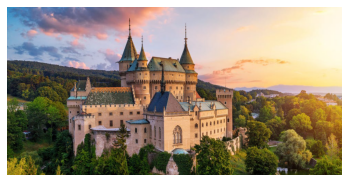

In [15]:
from tensorflow import keras
import matplotlib.pyplot as plt

# base_image_path = keras.utils.get_file(
#     "coast.jpg", origin="https://img-datasets.s3.amazonaws.com/coast.jpg")

base_image_path = keras.utils.get_file(
    "bojnice-castle-1603142898.jpg", origin="https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/bojnice-castle-1603142898.jpg?crop=1.00xw:0.752xh;0,0.0240xh&resize=980:*")


plt.axis("off")
plt.imshow(keras.utils.load_img(base_image_path))

**Instantiating a pretrained `InceptionV3` model**

In [18]:
from tensorflow.keras.applications import inception_v3
model = inception_v3.InceptionV3(weights="imagenet", include_top=False)

In [13]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_94 (Conv2D)             (None, None, None,   864         ['input_2[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization_94 (BatchN  (None, None, None,   96         ['conv2d_94[0][0]']              
 ormalization)                  32)                                                    

**Configuring the contribution of each layer to the DeepDream loss**

In [20]:
layer_settings = {
    "mixed4": 1.0,
    "mixed5": 1.5,
    "mixed6": 2.0,
    "mixed7": 2.5,
}


# layer_settings = {
#     "activation_5": 1.0,
#     "activation_48": 3.5,
#     # "conv2d_18": 1.0, 
#     # "mixed9_1": 0.5,
# }


outputs_dict = dict(
    [
        (layer.name, layer.output)
        for layer in [model.get_layer(name) for name in layer_settings.keys()]
    ]
)
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

**The DeepDream loss**

In [21]:
def compute_loss(input_image):
    features = feature_extractor(input_image)
    loss = tf.zeros(shape=())
    for name in features.keys():
        coeff = layer_settings[name]
        activation = features[name]
        loss += coeff * tf.reduce_mean(tf.square(activation[:, 2:-2, 2:-2, :]))
    return loss

**The DeepDream gradient ascent process**

In [22]:
import tensorflow as tf

@tf.function
def gradient_ascent_step(image, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image)
    grads = tape.gradient(loss, image)
    grads = tf.math.l2_normalize(grads)
    image += learning_rate * grads
    return loss, image


def gradient_ascent_loop(image, iterations, learning_rate, max_loss=None):
    for i in range(iterations):
        loss, image = gradient_ascent_step(image, learning_rate)
        if max_loss is not None and loss > max_loss:
            break
        print(f"... Loss value at step {i}: {loss:.2f}")
    return image

In [23]:
step = 20.
num_octave = 4
octave_scale = 1.4
iterations = 35
max_loss = 25.

**Image processing utilities**

In [24]:
import numpy as np

def preprocess_image(image_path):
    img = keras.utils.load_img(image_path)
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = keras.applications.inception_v3.preprocess_input(img)
    return img

def deprocess_image(img):
    img = img.reshape((img.shape[1], img.shape[2], 3))
    img /= 2.0
    img += 0.5
    img *= 255.
    img = np.clip(img, 0, 255).astype("uint8")
    return img

**Running gradient ascent over multiple successive "octaves"**

In [25]:
original_img = preprocess_image(base_image_path)
original_shape = original_img.shape[1:3]

successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]

shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])

img = tf.identity(original_img)
for i, shape in enumerate(successive_shapes):
    print(f"Processing octave {i} with shape {shape}")
    img = tf.image.resize(img, shape)
    img = gradient_ascent_loop(
        img, iterations=iterations, learning_rate=step, max_loss=max_loss
    )
    upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
    same_size_original = tf.image.resize(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img
    img += lost_detail
    shrunk_original_img = tf.image.resize(original_img, shape)

keras.utils.save_img("dream.png", deprocess_image(img.numpy()))

Processing octave 0 with shape (178, 357)
... Loss value at step 0: 1.24
... Loss value at step 1: 1.81
... Loss value at step 2: 2.48
... Loss value at step 3: 3.10
... Loss value at step 4: 3.70
... Loss value at step 5: 4.15
... Loss value at step 6: 4.67
... Loss value at step 7: 5.19
... Loss value at step 8: 5.56
... Loss value at step 9: 5.96
... Loss value at step 10: 6.49
... Loss value at step 11: 6.96
... Loss value at step 12: 7.57
... Loss value at step 13: 7.72
... Loss value at step 14: 8.49
... Loss value at step 15: 8.70
... Loss value at step 16: 9.19
... Loss value at step 17: 9.66
... Loss value at step 18: 10.16
... Loss value at step 19: 10.73
... Loss value at step 20: 10.98
... Loss value at step 21: 11.40
... Loss value at step 22: 11.30
... Loss value at step 23: 12.34
... Loss value at step 24: 12.24
... Loss value at step 25: 13.47
... Loss value at step 26: 13.45
... Loss value at step 27: 14.17
... Loss value at step 28: 14.30
... Loss value at step 29: 14

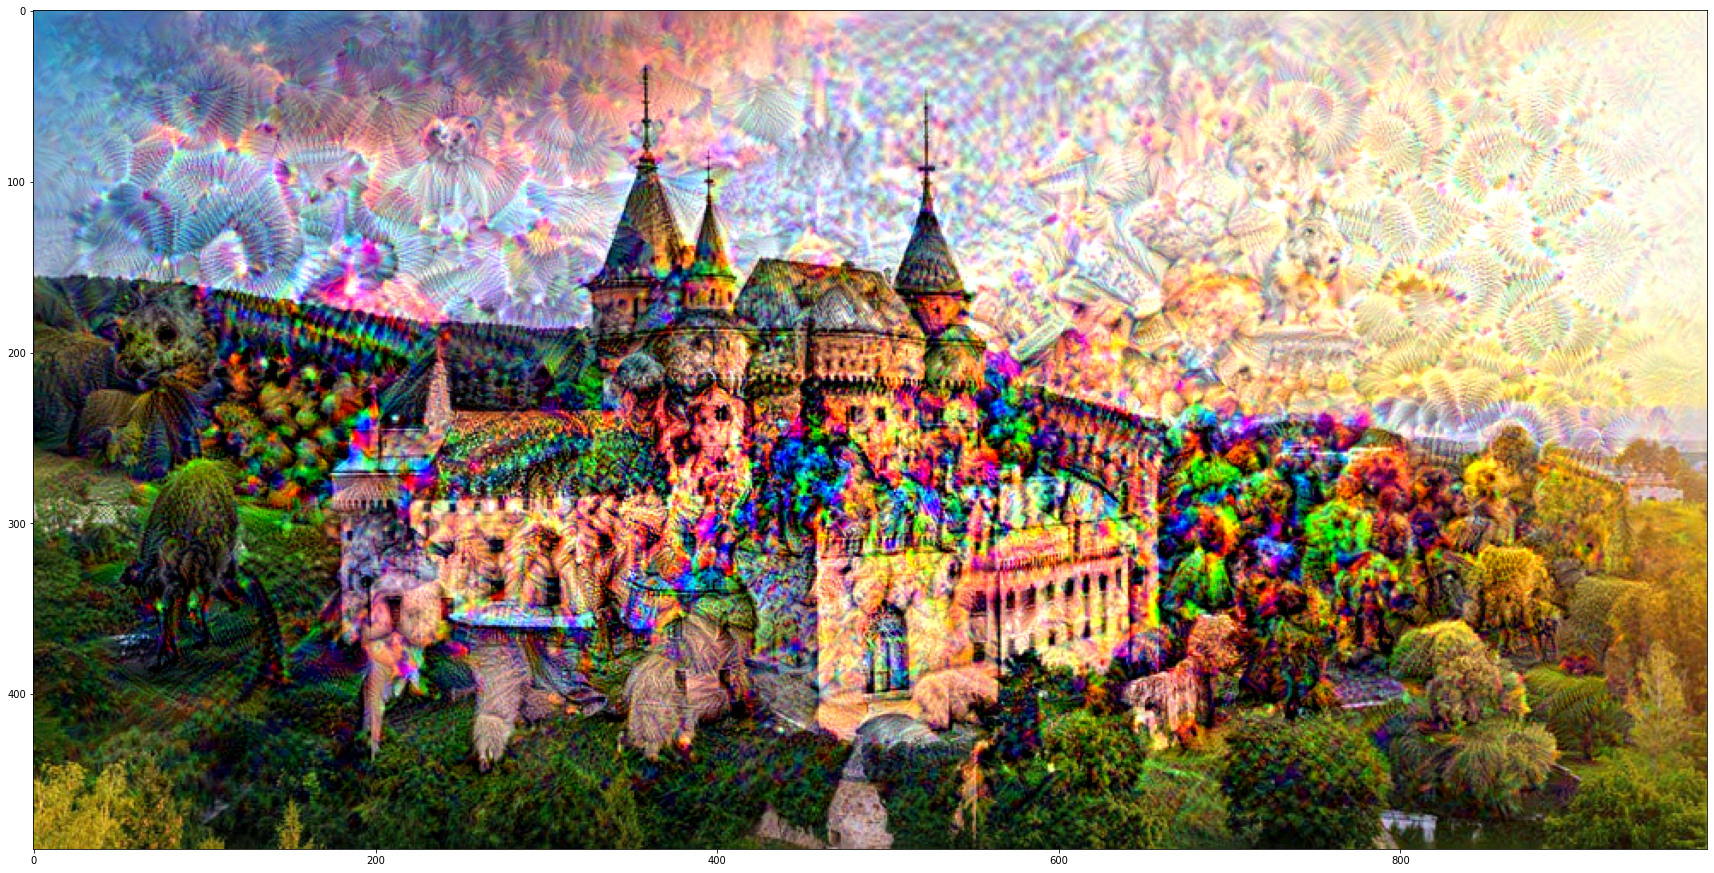

In [26]:


plt.figure(figsize = (30,40))
plt.imshow(keras.utils.load_img("dream.png"))


### Wrapping up